In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Import scoring metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [2]:
# Columns from kaggle dataset for reference
old_col= '''Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')'''

# Read in CSV

In [3]:
#df = pd.read_csv('~/Downloads/LoanStats3c.csv',header = 1)
#df.to_pickle('./data/loan_data_2014.zip',compression = 'zip')

# Drop unnecessary columns:

In [4]:
df = pd.read_pickle('./data/loan_data_2014.zip',compression = 'zip')
df.shape

(235631, 145)

In [5]:
# Only take rows of loans that are charged off or fully paid as results
df = df.loc[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [6]:
df=df.drop(columns = [
        # Only looking at loans for individuals, not joint
        'annual_inc_joint',
        'application_type',
        'dti_joint',
        'verification_status_joint',
        'revol_bal_joint', 

        # Don't need specific ID info
        'id',
        'member_id',
    
        # Only care about information available pre loan
        'collection_recovery_fee',
        'collections_12_mths_ex_med',
        'delinq_amnt',
        'last_credit_pull_d',
        'last_pymnt_amnt',
        'last_pymnt_d',
        'next_pymnt_d',
        'pymnt_plan',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_int',
        'total_rec_late_fee',
        'total_rec_prncp',
        # Hard to classify, may use regex text processing in future
        'emp_title',
    
        # hardship info is post issuing
        'hardship_flag',
        'hardship_status',
        'hardship_type',
        'hardship_reason',
        'deferral_term',
        'hardship_amount',
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'hardship_length',
        'hardship_dpd',
        'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount',
        'hardship_last_payment_amount',
    

        # Trying to extrapolate beyond certain issuing dates of loans
        'issue_d',
        'mths_since_last_major_derog',
        'mths_since_last_record',
        'mths_since_recent_inq',
        'num_tl_30dpd',
        'num_tl_120dpd_2m',
        
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'desc',
    
        # sub_grade category already contains grade
        'grade',
    
        # This is for investors / loan funding
        'initial_list_status',
        'funded_amnt',
        'funded_amnt_inv',              
        # Probably useful metrics, but all NaN in this dataset              
        'open_acc_6m',                 
        'open_il_12m',
        'open_il_24m',                     
        'open_act_il',   
        'open_rv_12m',
        'open_rv_24m',
                      
        'out_prncp', 
        'out_prncp_inv',
        'policy_code',
        'recoveries',
        # Columns related to debt settlement; we only care about pre loan features              
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        # Only looking for one applicant 
        #'sec_app_fico_range_low', 
        #'sec_app_fico_range_high', 
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths', 
        'sec_app_mort_acc', 
        'sec_app_open_acc', 
        'sec_app_revol_util',
        'sec_app_open_act_il',
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med', 
        'sec_app_mths_since_last_major_derog', 
        'title',
        'total_cu_tl',
                      
        'url', 
        # May be good to look at later
        'zip_code'])

print('Before dropping NaN\'s: ',df.shape)
df.dropna(how='all', inplace = True)
print('After dropping NaN Rows: ',df.shape)
pre_drop_col = df.columns
df.dropna(axis=1, how='all',inplace = True)
print('After dropping NaN Columns: ',df.shape)
post_drop_col = df.columns

Before dropping NaN's:  (223102, 67)
After dropping NaN Rows:  (223102, 67)
After dropping NaN Columns:  (223102, 60)


In [7]:
dropped_nan_columns = set(pre_drop_col) - set(post_drop_col)
print("Dropped NaN Columns: ", dropped_nan_columns)

Dropped NaN Columns:  {'all_util', 'mths_since_rcnt_il', 'il_util', 'max_bal_bc', 'total_bal_il', 'inq_fi', 'inq_last_12m'}


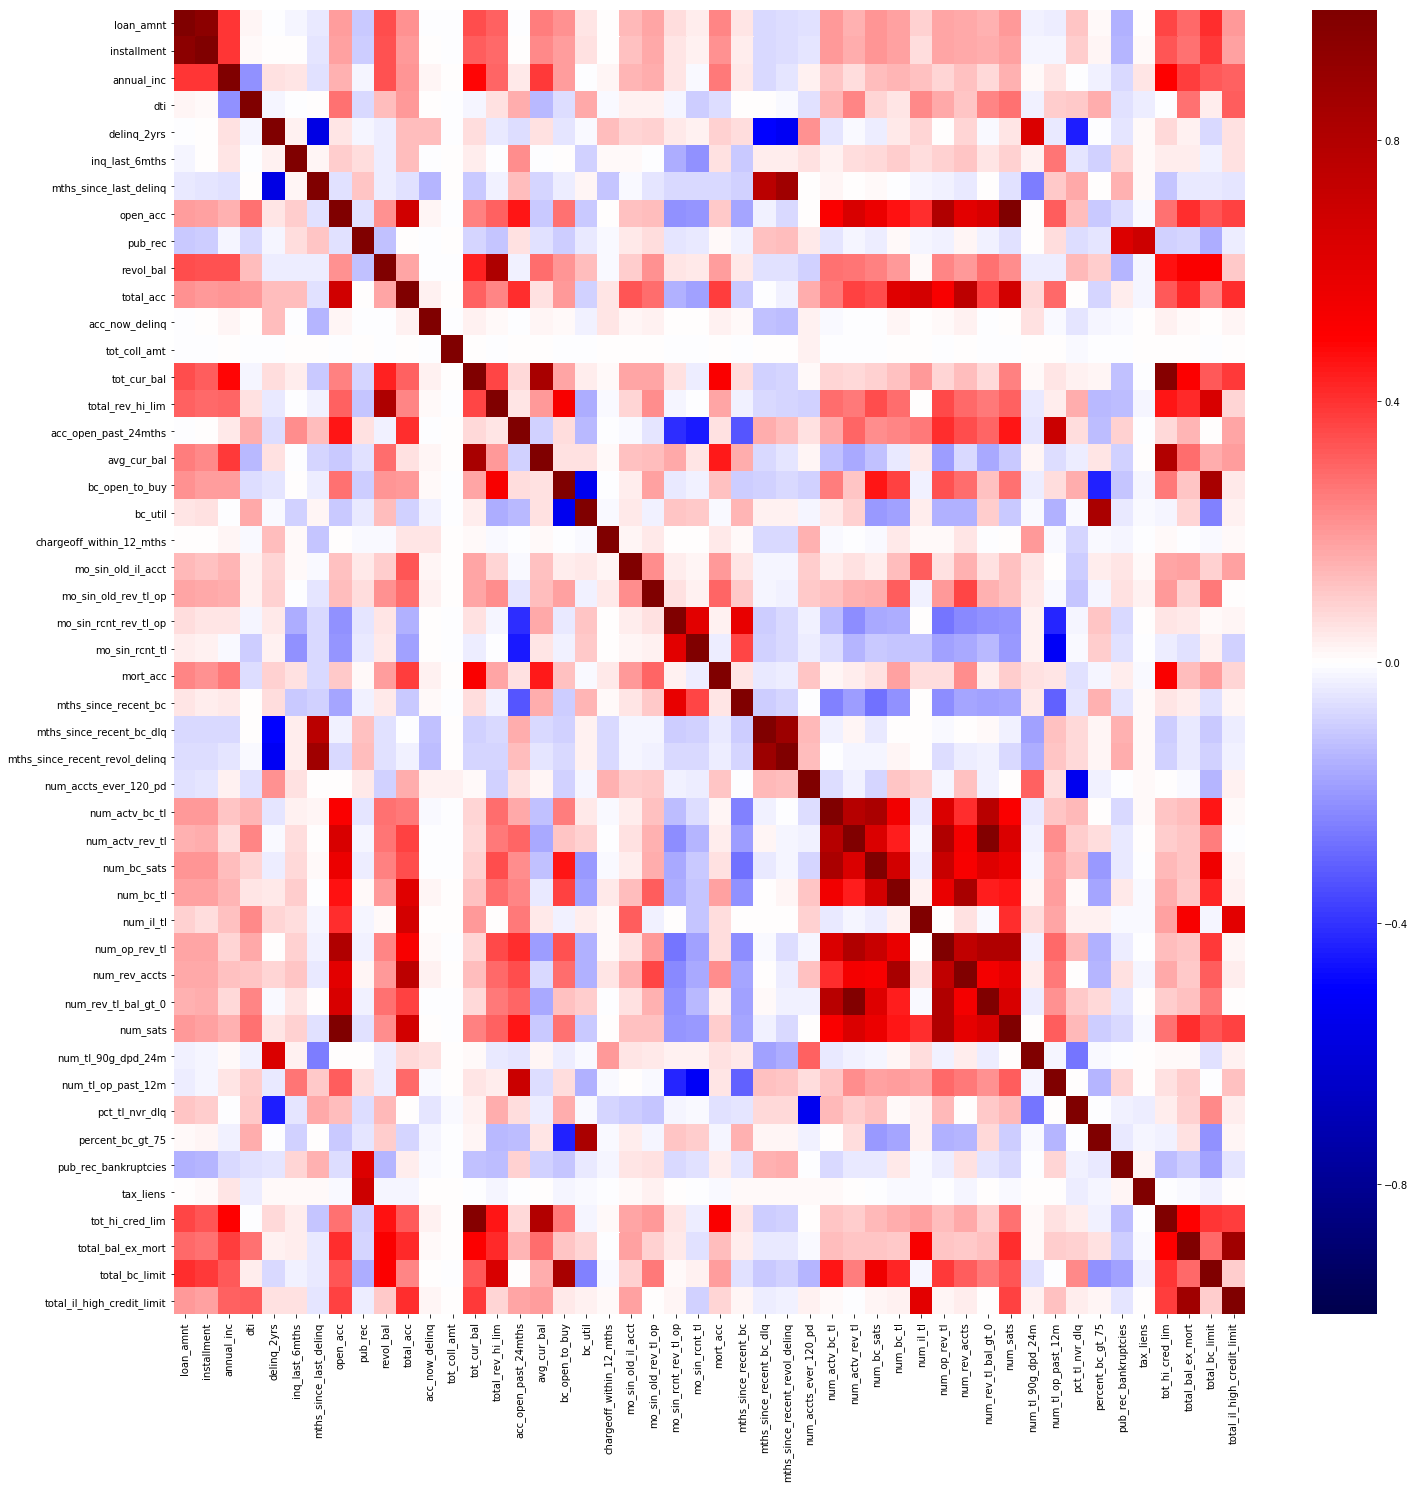

In [8]:

plt.figure(figsize=(24, 24))

sns.heatmap(df.corr(),vmin = -1, vmax = 1, cmap = 'seismic')

In [9]:
df.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
47727,15000.0,60 months,22.15%,415.57,E5,10+ years,MORTGAGE,72000.0,Verified,Fully Paid,credit_card,AR,26.53,0.0,Aug-2002,3.0,66.0,9.0,1.0,2926.0,56.3%,30.0,0.0,0.0,191051.0,5200.0,5.0,21228.0,170.0,93.9,0.0,142.0,146.0,22.0,10.0,2.0,58.0,66.0,66.0,1.0,1.0,2.0,1.0,9.0,15.0,3.0,13.0,2.0,9.0,0.0,2.0,95.8,100.0,1.0,0.0,213749.0,62032.0,2800.0,74279.0,Cash
129417,18000.0,60 months,13.35%,412.79,C2,10+ years,MORTGAGE,127990.0,Not Verified,Fully Paid,credit_card,KS,17.59,1.0,Aug-1985,0.0,8.0,12.0,1.0,17494.0,52.1%,28.0,0.0,382.0,66444.0,33600.0,4.0,6040.0,6201.0,64.4,0.0,346.0,153.0,9.0,9.0,5.0,84.0,31.0,8.0,0.0,4.0,8.0,4.0,6.0,9.0,8.0,14.0,8.0,12.0,0.0,1.0,85.2,50.0,0.0,1.0,120741.0,41410.0,17400.0,54471.0,Cash
30070,3500.0,36 months,13.66%,119.05,C3,< 1 year,MORTGAGE,20000.0,Not Verified,Fully Paid,debt_consolidation,MI,26.95,0.0,Jun-2007,2.0,NaN,16.0,0.0,4275.0,16.1%,26.0,0.0,0.0,70710.0,26600.0,11.0,5051.0,3896.0,39.1,0.0,45.0,88.0,2.0,2.0,1.0,3.0,NaN,NaN,0.0,4.0,7.0,4.0,4.0,4.0,14.0,21.0,7.0,16.0,0.0,4.0,100.0,0.0,0.0,0.0,101326.0,12691.0,6400.0,11689.0,Cash
215518,35000.0,36 months,13.98%,1195.88,C1,10+ years,MORTGAGE,187000.0,Source Verified,Fully Paid,home_improvement,KY,20.17,0.0,Jan-1991,2.0,NaN,24.0,0.0,19900.0,24.4%,45.0,0.0,0.0,414601.0,81700.0,9.0,18846.0,55158.0,22.4,0.0,227.0,277.0,7.0,7.0,5.0,70.0,NaN,NaN,0.0,5.0,8.0,13.0,24.0,7.0,18.0,33.0,8.0,24.0,0.0,6.0,100.0,0.0,0.0,0.0,522802.0,210667.0,71100.0,222602.0,Cash
221136,21000.0,36 months,8.90%,666.82,A5,6 years,RENT,175000.0,Source Verified,Fully Paid,credit_card,TX,7.77,1.0,Oct-2002,0.0,16.0,15.0,0.0,13100.0,30.7%,49.0,0.0,150.0,141946.0,42700.0,5.0,9463.0,19002.0,37.7,0.0,135.0,107.0,1.0,1.0,7.0,25.0,NaN,NaN,1.0,3.0,6.0,4.0,9.0,23.0,11.0,19.0,6.0,15.0,1.0,2.0,97.9,0.0,0.0,0.0,164418.0,141946.0,30500.0,121718.0,Cash


In [10]:
#df[df['num_tl_120dpd_2m'] >= 1][['num_tl_30dpd','num_tl_120dpd_2m','num_tl_90g_dpd_24m']]

In [11]:
# df[['int_rate','grade','sub_grade']].sort_values(by = 'int_rate')

# Clean Columns

In [12]:
def drop_percentage_signs(df, column_name):
    new_column_name = column_name + '_percent'
    df[new_column_name] = df[column_name].astype(str).str[:-1].astype(np.float64)
    return df.drop(columns = [column_name])

In [13]:
df.shape

(223102, 60)

In [14]:
#df['revol_util'].fillna('0%',inplace = True)
#df['revol_util'] =df['revol_util'].astype(str).str[:-1]


In [15]:
# Clean columns
# Convert loan terms into two categories 'short' and 'long'
df['term'] = df['term'].str.replace('36 months','short').str.replace('60 months','long').str.strip()

# Convert interest rate from percentage to float
df['int_rate'].dropna(axis = 0,how = 'any', inplace = True)
df=drop_percentage_signs(df,'int_rate')


# Fill Na's with 0.0% in revolving balance (unused revolving balance counts as NaN)
df['revol_util'].fillna(value = '0.0%',inplace = True)
df=drop_percentage_signs(df, 'revol_util')

In [16]:
df.shape

(223102, 60)

# Categorize 'Months Since' Variables

- First do a pd.cut() to bin the data into categories.
- Then fill nans as another category
- patsy.dmatrix does 'treatment' to do onehot encoding automatically on string columns


In [17]:
df['mths_since_last_delinq'] = \
pd.cut(df['mths_since_last_delinq'],5,labels =
       ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_bc'] = \
pd.cut(df['mths_since_recent_bc'],5,labels =
       ['0-10 years','10-20 years','20-30 years','30-40 years','40-50 years']
      ).cat.add_categories('never').fillna('never')# 

df['mths_since_recent_bc_dlq'] = \
pd.cut(df['mths_since_recent_bc_dlq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_revol_delinq'] = \
pd.cut(df['mths_since_recent_revol_delinq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 
df['mo_sin_old_il_acct'] = \
pd.cut(df['mo_sin_old_il_acct'],5).cat.add_categories('never').fillna('never')

In [18]:
def add_days_since_col(df,column_name):
    new_col_name = 'days_since_' + column_name
    df[new_col_name] = df[column_name].apply(lambda x: (dt.datetime.today().date() - 
                                                      dt.datetime.strptime(x,'%b-%Y').date()).days)
    return df.drop(columns = [column_name])
# df['days_since_earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: (dt.datetime.today().date() - 
#                                                       dt.datetime.strptime(x,'%b-%Y').date()).days)
#df=df.drop(columns = ['earliest_cr_line'])

df = add_days_since_col(df,'earliest_cr_line')
# Last credit pulled has data leakage because credit is constantly pulled for non-defaulted loans. 
#df= df.dropna(subset = ['last_credit_pull_d'])
#df = add_days_since_col(df,'last_credit_pull_d')

In [19]:
df.sample(5)

,loan_amnt,term,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,int_rate_percent,revol_util_percent,days_since_earliest_cr_line
15717,7000.0,short,214.52,A2,4 years,RENT,88728.0,Not Verified,Fully Paid,debt_consolidation,MO,9.89,0.0,0.0,never,13.0,0.0,20462.0,26.0,0.0,0.0,22211.0,57600.0,5.0,2221.0,22408.0,45.7,0.0,"(100.2, 200.4]",243.0,2.0,2.0,2.0,0-10 years,never,never,0.0,2.0,6.0,5.0,9.0,2.0,12.0,22.0,6.0,13.0,0.0,1.0,100.0,25.0,0.0,0.0,73201.0,22211.0,41300.0,15601.0,Cash,6.49,35.5,9039
25347,25000.0,long,549.07,B4,10+ years,MORTGAGE,90000.0,Source Verified,Fully Paid,debt_consolidation,DC,9.76,0.0,0.0,never,12.0,0.0,16593.0,17.0,0.0,0.0,227220.0,50800.0,7.0,22722.0,13205.0,9.6,0.0,"(-0.501, 100.2]",196.0,2.0,2.0,3.0,0-10 years,never,never,0.0,1.0,2.0,3.0,3.0,2.0,10.0,12.0,2.0,12.0,0.0,2.0,100.0,0.0,0.0,0.0,291650.0,29709.0,14600.0,17000.0,Cash,11.44,32.7,8430
67014,10075.0,long,290.31,F2,2 years,RENT,28000.0,Source Verified,Charged Off,debt_consolidation,CO,33.65,3.0,0.0,0-3 years,11.0,0.0,19516.0,37.0,1.0,0.0,30958.0,43700.0,4.0,3096.0,18765.0,18.8,0.0,"(100.2, 200.4]",152.0,13.0,7.0,0.0,0-10 years,never,0-3 years,0.0,3.0,5.0,5.0,7.0,15.0,10.0,22.0,5.0,11.0,1.0,1.0,97.1,20.0,0.0,0.0,57904.0,30958.0,23100.0,14204.0,Cash,24.08,44.7,6574
192913,23000.0,short,706.19,A2,10+ years,MORTGAGE,100000.0,Verified,Fully Paid,debt_consolidation,RI,25.63,0.0,1.0,3-6 years,12.0,0.0,12545.0,31.0,0.0,0.0,227852.0,85700.0,4.0,18988.0,63855.0,16.4,0.0,"(100.2, 200.4]",355.0,6.0,6.0,5.0,0-10 years,never,never,0.0,2.0,2.0,5.0,9.0,11.0,8.0,15.0,2.0,12.0,0.0,2.0,96.8,20.0,0.0,0.0,329897.0,76338.0,76400.0,84197.0,Cash,6.62,14.6,12691
147802,8400.0,short,277.68,B4,8 years,RENT,60000.0,Source Verified,Fully Paid,debt_consolidation,AL,4.40,0.0,0.0,never,7.0,1.0,8509.0,25.0,0.0,0.0,28033.0,12450.0,2.0,4004.0,2325.0,84.0,0.0,"(100.2, 200.4]",575.0,12.0,12.0,1.0,0-10 years,never,never,0.0,4.0,6.0,5.0,10.0,3.0,6.0,21.0,5.0,7.0,0.0,1.0,56.0,75.0,1.0,0.0,57405.0,8509.0,9300.0,0.0,Cash,11.67,68.0,19327


# Patsy.dmatrix (pass string like last project, but no y~)

In [20]:
df.shape

(223102, 60)

In [21]:
# What NA Columns are we dropping
df.isnull().sum()[df.isnull().sum() != 0]

emp_length          11554
avg_cur_bal             6
bc_open_to_buy       2328
bc_util              2482
percent_bc_gt_75     2437
dtype: int64

# Modeling begins here

In [22]:
df_temp = df.dropna()
# Only look at low grades, high interest
# df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('D' in element) | ('E' in element))]

# Only look at good grades, low interest
df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('A' in element) |
                                                 ('B' in element) |
                                                 ('C' in element))]

#Percentage of target
sum(df_temp['loan_status'] == 'Charged Off')/df_temp.shape[0]

0.1294496860625189

In [23]:
len(df_temp.columns)

60

In [ ]:
# Convert target to binary,
df_temp['loan_status'] = df_temp['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

In [ ]:
# Define a 'basic' dataframe that only predicts off LendingClub sub_grade feature
df_basic= df_temp[['loan_status','sub_grade']]
df_basic.shape

(148915, 2)

In [ ]:
def patsy_string_from_df(df):
    """Makes patsy string from dataframe df. Drops 'loan_status' variable by default."""
    df = df.drop(columns = ['loan_status']) # Drop the target variable, in this case it's loan_status
    patsy_string = ''
    for title in df.columns:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    # print("Patsy String: " +patsy_string)
    return patsy_string

In [ ]:
# Make patsy design matrix from all dataframe 
# This takes care of onehot variables
X = patsy.dmatrix(patsy_string_from_df(df_temp),df_temp)
y = df_temp['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)

In [ ]:
Xb = patsy.dmatrix(patsy_string_from_df(df_basic),df_basic)
yb = df_basic['loan_status'].values
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=123456)

In [ ]:
model_dict = {'rfc': RandomForestClassifier(n_estimators = 9),
             'lm' : LogisticRegression(max_iter =10000,solver='sag'),
             'gnb' : GaussianNB(),
             'mlp' : MLPClassifier()}


In [ ]:
def make_model(mdl_key,X_train,y_train,X_test):
    """Uses key from model_dict and trains it on X_train, y_train, then returns \
    the model object used and predicted values on X_test"""
    assert (mdl_key in model_dict.keys()),"Model tag not in model_dict keys!"
    mdl = model_dict[mdl_key]
    mdl.fit(X_train,y_train)
    predicted = mdl.predict(X_test)
    return mdl, predicted

In [ ]:
rfc, predicted = make_model('rfc',X_train,y_train,X_test)

In [ ]:
lm, predicted = make_model('lm',X_train,y_train,X_test)

In [ ]:
gnb, predicted = make_model('gnb',X_train,y_train,X_test)

In [ ]:
mlp, predicted = make_model('mlp',X_train,y_train,X_test)

In [ ]:
# Fit random forest to basic model (sub_grade only)
rfc_b = RandomForestClassifier()
rfc_b.fit(Xb_train,yb_train)
predicted_b = rfc_b.predict(Xb_test)

In [ ]:
def make_confusion_matrix(model, threshold=.2):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    mat_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    plt.figure(figsize=(8, 8))
    sns.heatmap(mat_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Paid off', 'Defaulted'],
           yticklabels=['Paid off', 'Defaulted']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title(str(type(model)))
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
#make_confusion_matrix(rfc)



In [ ]:
models=[rfc,lm,gnb,mlp]
plt.figure(figsize=(15, 12))
plt.plot(fpr_b,tpr_b,lw=2, label = 'RFC on only sub_grade' +\
         ', AUC: ' + str(roc_auc_score(yb_test, rfc_b.predict_proba(Xb_test)[:,1]))[:6])
def plot_models():
    ''' Plots all models in the models list defined above. Also plots a dotted line\
    representing the curve of a random model.'''
    model_info=list()
    for model in models:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        f1 = f1_score(y_test,model.predict(X_test))
        model_info.append((model, auc_score,f1))
        plt.plot(fpr, tpr,lw=2, label = str(model)[:str(model).find('(')] + ', AUC: ' + str(auc_score)[:6])
    
    #Random guess line
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc='upper left')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Scores For Various Models Predicting Defaulting Loans');
    return model_info
plot_models()



        

In [ ]:
# Let's make a slightly better model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)
lm = LogisticRegression(C = 100)
lm.fit(X_train, y_train)
print("Logistic score: {:6.4f}".format(lm.score(X_train,y_train)))

make_confusion_matrix(lm)

In [ ]:
Xb_test

# Write a COST FUNCTION
(Loans classified as defaulted but fully paid off * average paid off loan amount ) - 
(loans classified as paid off but defaulted * average loss to defaulted loan amount)